# In the name of God

## Mostafa Najafi
## 98209218

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp
import shutil
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.backend as KB
import tensorflow.keras.layers as KL
from skimage.transform import resize
from skimage.io import imsave
from sklearn.metrics import confusion_matrix
import imgaug.augmenters as iaa
import progressbar

from model import efficientdet
from generators.csv_ import CSVGenerator
from eval.common import _get_detections, _get_annotations
from utils.compute_overlap import compute_overlap

from classification_model import get_image_crops, create_model, CropSequence

# Parameters

In [3]:
ED_MODEL_WEIGHTS = './ed_model-phi2-wbifpn.h5'
PHI = 2
WBIFPN = True  # weighted bifpn
GENERATOR_BATCH_SIZE = 64

TRAIN_ANNOTATIONS_PATH = './datasets/malaria/train.csv'
VAL_ANNOTATIONS_PATH = './datasets/malaria/val.csv'
TEST_ANNOTATIONS_PATH = './datasets/malaria/test.csv'
CLASSES_PATH = './datasets/malaria/classes.csv'

IOU_THRESHOLD = 0.65
SCORE_THRESHOLD = 0.3
MAX_DETECTIONS = 250

CROP_SIZE = (200, 200)
CROP_TRAIN_PATH = './datasets/malaria/crops/train'
CROP_VAL_PATH = './datasets/malaria/crops/val'
CROP_TEST_PATH = './datasets/malaria/crops/test'

# Prepare Data

In [4]:
# Generators
train_generator = CSVGenerator(
    TRAIN_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

val_generator = CSVGenerator(
    VAL_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

test_generator = CSVGenerator(
    TEST_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

num_classes = train_generator.num_classes()

In [5]:
# Get boxes
_, ed_model = efficientdet(
    PHI,
    num_classes = num_classes,
    weighted_bifpn = WBIFPN,
)
ed_model.load_weights(ED_MODEL_WEIGHTS, by_name=True)

train_detections = _get_detections(train_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
train_annotations = _get_annotations(train_generator)

val_detections = _get_detections(val_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
val_annotations = _get_annotations(val_generator)

test_detections = _get_detections(test_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
test_annotations = _get_annotations(test_generator)

Instructions for updating:
Use fn_output_signature instead
Running network: 100% (966 of 966) |#####| Elapsed Time: 0:01:35 Time:  0:01:35
Parsing annotations: 100% (966 of 966) |#| Elapsed Time: 0:00:00 Time:  0:00:00
Running network: 100% (242 of 242) |#####| Elapsed Time: 0:00:22 Time:  0:00:22
Parsing annotations: 100% (242 of 242) |#| Elapsed Time: 0:00:00 Time:  0:00:00
Running network: 100% (120 of 120) |#####| Elapsed Time: 0:00:10 Time:  0:00:10
Parsing annotations: 100% (120 of 120) |#| Elapsed Time: 0:00:00 Time:  0:00:00


In [6]:
def save_crops(generator, detections, annotations, save_path):
    for label in range(num_classes):
        label_path = osp.join(save_path, str(label))
        if not osp.exists(label_path):
            os.makedirs(label_path)

    for i in progressbar.progressbar(range(generator.size()), prefix='Get Crops: '):
        img_crops, img_labels = get_image_crops(generator, detections, annotations, i, CROP_SIZE, IOU_THRESHOLD)
        for index, crop, label in zip(range(len(img_crops)), img_crops, img_labels):
            img_path = osp.join(save_path, str(label), f'{i}-{index}.jpg')
            imsave(img_path, crop)

In [77]:
save_crops(train_generator, train_detections, train_annotations, CROP_TRAIN_PATH)
save_crops(val_generator, val_detections, val_annotations, CROP_VAL_PATH)
save_crops(test_generator, test_detections, test_annotations, CROP_TEST_PATH)

Get Crops: 100% (966 of 966) |###########| Elapsed Time: 0:09:14 Time:  0:09:14
Get Crops: 100% (242 of 242) |###########| Elapsed Time: 0:02:15 Time:  0:02:15
Get Crops: 100% (120 of 120) |###########| Elapsed Time: 0:00:50 Time:  0:00:50


# Sequences

In [5]:
train_augmenter = iaa.Sometimes(0.5, iaa.Sequential([
    iaa.Affine(scale=(0.9, 1.3)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rotate((-45, 45)),
]))

train_sequence = CropSequence(CROP_TRAIN_PATH, num_classes, 128, augmenter=train_augmenter, calc_weights=False)
val_sequence = CropSequence(CROP_VAL_PATH, num_classes, 128, augmenter=None)
test_sequence = CropSequence(CROP_TEST_PATH, num_classes, 128, augmenter=None)

train_sequence.weights

array([1., 1., 1., 1., 1., 1., 1.])

# Create Model

In [6]:
model = create_model((*CROP_SIZE, 3), num_classes, verbose=True)

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 200, 200, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 200, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
GlobalAvgPool2D (GlobalAvera (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 8,416,703
Non-trainable params: 12,459,120
_________________________________________

# Train Model

In [7]:
def focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        p = tf.reduce_sum(y_true * y_pred, axis=-1)
        out = -tf.reduce_mean(tf.pow(1.0 - p, gamma) * tf.math.log(p + 1e-9))
        return out
    return loss

model.compile(
    optimizer = K.optimizers.Adam(lr=1e-3),
    loss = focal_loss(gamma=2),
    metrics = [K.metrics.CategoricalAccuracy(name='acc')],
)

In [8]:
today = datetime.now().strftime('%Y%m%d-%H%M%S')
checkpoint_base_path = f'checkpoints/class-{today}'
if not osp.exists(checkpoint_base_path):
    os.makedirs(checkpoint_base_path)
print(f'Save checkpoints in {checkpoint_base_path}')

result = model.fit(
    x = train_sequence,
    shuffle = True,
    initial_epoch = 0,
    epochs = 25,
    steps_per_epoch = 100,
    verbose = 1,
    validation_data = val_sequence,
    max_queue_size = 10,
    workers = 4,
    use_multiprocessing = False,
    callbacks = [
        K.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1,
                                      mode='min', min_delta=1e-4, min_lr=1e-6),
        K.callbacks.ModelCheckpoint(
            osp.join(checkpoint_base_path, '{epoch:02d}_{loss:.4f}_{val_loss:.4f}.h5'),
            verbose = 0,
            save_weights_only = True,
        ),
    ],
)

Save checkpoints in checkpoints/class-20201212-120751
Epoch 1/25
100/100 [==============================] - 24s 238ms/step - loss: 1.3055 - acc: 0.5945 - val_loss: 0.9240 - val_acc: 0.5706
Epoch 2/25
100/100 [==============================] - 22s 218ms/step - loss: 0.8223 - acc: 0.6102 - val_loss: 0.7370 - val_acc: 0.5992
Epoch 3/25
100/100 [==============================] - 22s 221ms/step - loss: 0.9156 - acc: 0.5885 - val_loss: 0.6900 - val_acc: 0.5930
Epoch 4/25
100/100 [==============================] - 22s 221ms/step - loss: 0.5570 - acc: 0.6687 - val_loss: 0.5713 - val_acc: 0.6810
Epoch 5/25
100/100 [==============================] - 22s 221ms/step - loss: 0.4256 - acc: 0.7413 - val_loss: 0.6591 - val_acc: 0.7035
Epoch 6/25
100/100 [==============================] - 22s 220ms/step - loss: 0.4111 - acc: 0.7456 - val_loss: 0.3274 - val_acc: 0.7710
Epoch 7/25
100/100 [==============================] - 22s 219ms/step - loss: 0.2739 - acc: 0.7860 - val_loss: 0.2469 - val_acc: 0.7975
E

In [9]:
y_true = val_sequence.y
y_pred = model.predict(val_sequence, verbose=1)

4/4 [==============================] - 1s 144ms/step


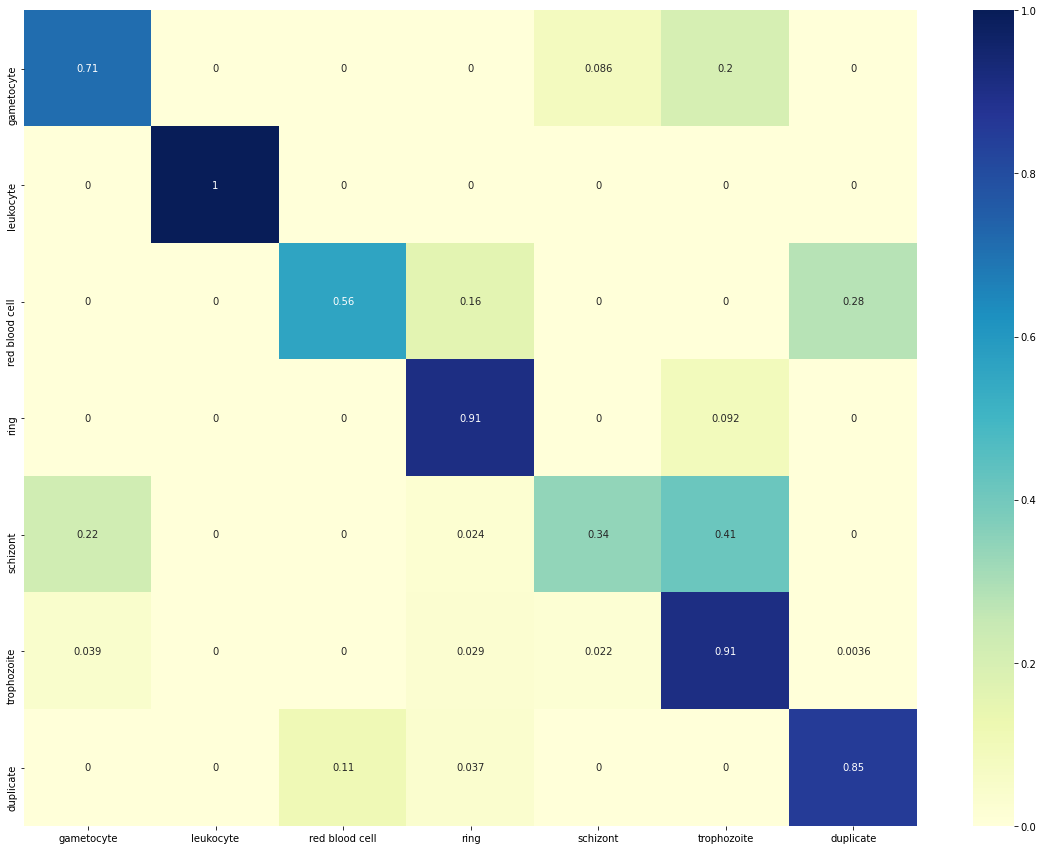

In [10]:
plt.figure(figsize=(20, 15))
cf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=range(num_classes), normalize='true')
ticklabels = ['gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite', 'duplicate']
_ = sns.heatmap(cf_matrix, annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='YlGnBu')